# Farfetch DS Exercise
## March 2nd, 2017
### Dr Jose M Albornoz

# Import necessary modules

In [45]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import cm
style.use('fivethirtyeight')
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples
from sklearn import metrics
from sklearn.datasets import make_blobs

RANDOM_STATE = 801

# 1 Detecting a marketing promotion

In the data file named marketing_promo.csv you will find data related to traffic and order activity over a period of several months. During this period a promotion offering free shipping was launched on the website. All visitors were exposed to the promotion and once started it remained active for all of the remaining days in the data you have available.

Based on the available data, deduce which day the promotion was launched.


## 1.1 Load data

In [167]:
marketing_0 = pd.read_csv('marketing_promo.csv')

In [168]:
marketing_0.head()

,Day,visits,orders
0,1,3316,17
1,2,3654,23
2,3,3437,14
3,4,3368,5
4,5,3588,16


In [169]:
marketing_0.shape

(122, 3)

The data represents web site visits and orders during a period of 122 days

## 1.2 Exploratory analysis: plot data

We want to have an idea of what the 'visits' and 'orders' time series look like

(0, 122)

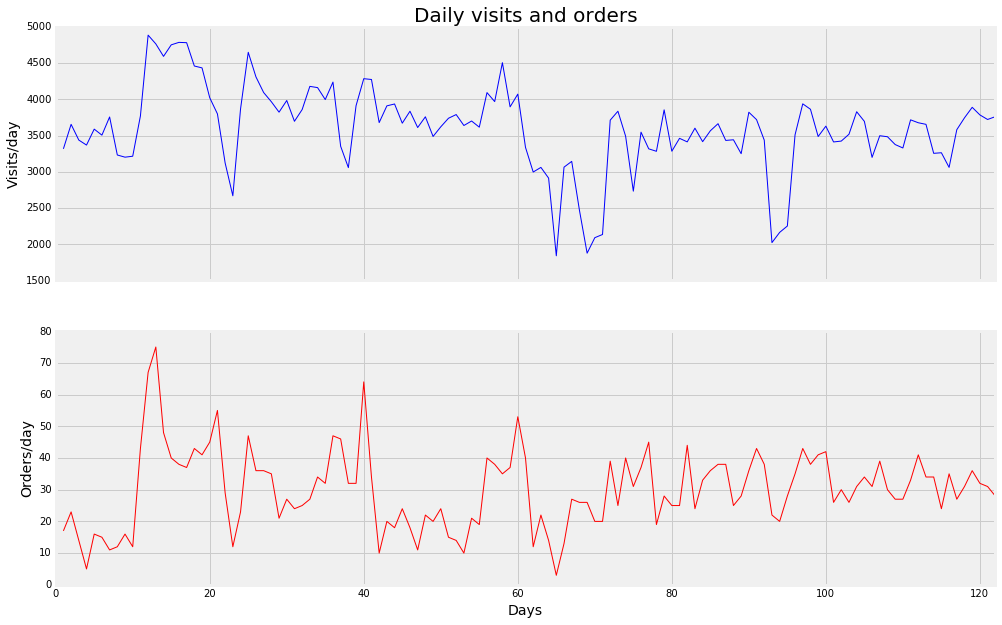

In [170]:
f, axarr = plt.subplots(2, sharex=True, figsize=(15,10), dpi=100)

axarr[0].plot(marketing_0.Day, marketing_0.visits, color="blue", linewidth=1.0, linestyle="-")
axarr[0].set_title('Daily visits and orders', fontsize=20)
axarr[0].set_ylabel('Visits/day', fontsize=14)

axarr[1].plot(marketing_0.Day, marketing_0.orders, color="red", linewidth=1.0, linestyle="-")
axarr[1].set_ylabel('Orders/day', fontsize=14)
axarr[1].set_xlabel('Days', fontsize=14)
axarr[1].set_xlim(0,122)

As seen from the above plots, there are no obvious indications of a rise in visits and/or orders that could signal the start of the promotion.

A better proxy of the effect of the promotion is the daily average number of orders per visit, obtained by dividing number of orders by number of visits for any particular day. Let's calculate and plot this quantity.

In [171]:
marketing_0['orders_per_visit'] = marketing_0['orders']/marketing_0['visits']

(0, 122)

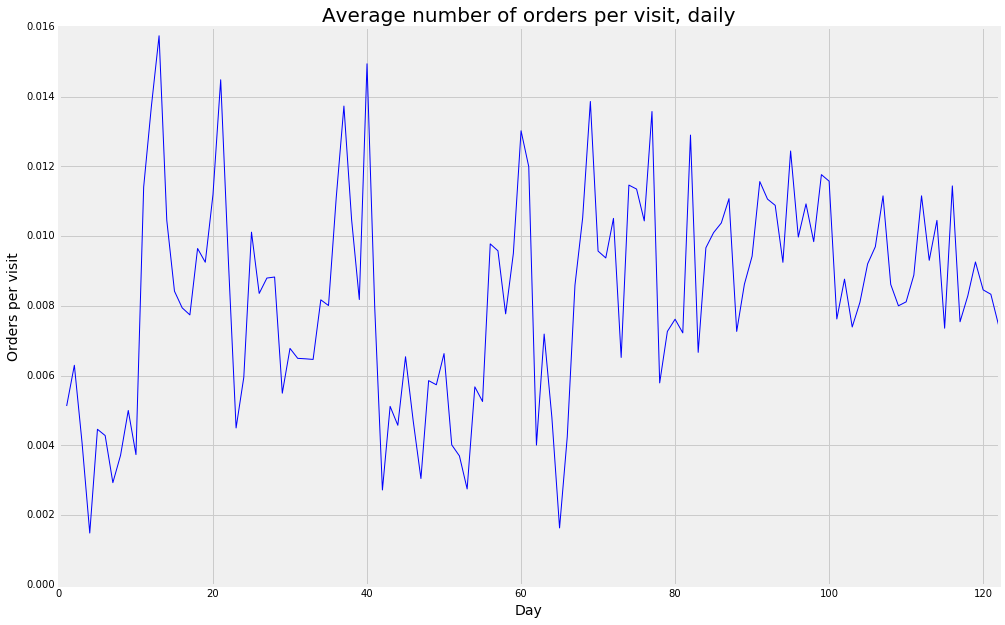

In [213]:
fig = plt.figure(figsize=(15,10))

plt.plot(marketing_0.Day, marketing_0['orders_per_visit'], color="blue", linewidth=1.0, linestyle="-")
plt.xlabel('Day', fontsize=14)
plt.ylabel('Orders per visit', fontsize=14)
plt.title('Average number of orders per visit, daily', fontsize=20)
plt.xlim(0,122)

Once again, there are no obvious indications of the start of the promotion in the orders per visit time series. 
We will now look at the daily percent change in the average number of orders per visit in order to come up with a simple change point estimate.

## 1.3 Change point estimation

In order to come up with an estimate of the start date of the promotion we will now look at the percent change in the average number of orders per visit, computed over a range of days. 

The idea is that the date associated to a sharp increase in the number of orders per day (that is, the date that marks the start of the promotion) must be consistent when this increase is computed across a range of time periods. We will compute this percent increase in periods ranging from 1 to 5 days.

In [211]:
marketing_0['orders_per_visit_percent_change_1day'] = marketing_0['orders_per_visit'].pct_change(periods=-1)
marketing_0['orders_per_visit_percent_change_2day'] = marketing_0['orders_per_visit'].pct_change(periods=-2)
marketing_0['orders_per_visit_percent_change_3day'] = marketing_0['orders_per_visit'].pct_change(periods=-3)
marketing_0['orders_per_visit_percent_change_4day'] = marketing_0['orders_per_visit'].pct_change(periods=-4)
marketing_0['orders_per_visit_percent_change_5day'] = marketing_0['orders_per_visit'].pct_change(periods=-5)
marketing_0['orders_per_visit_percent_change_6day'] = marketing_0['orders_per_visit'].pct_change(periods=-6)

(0, 122)

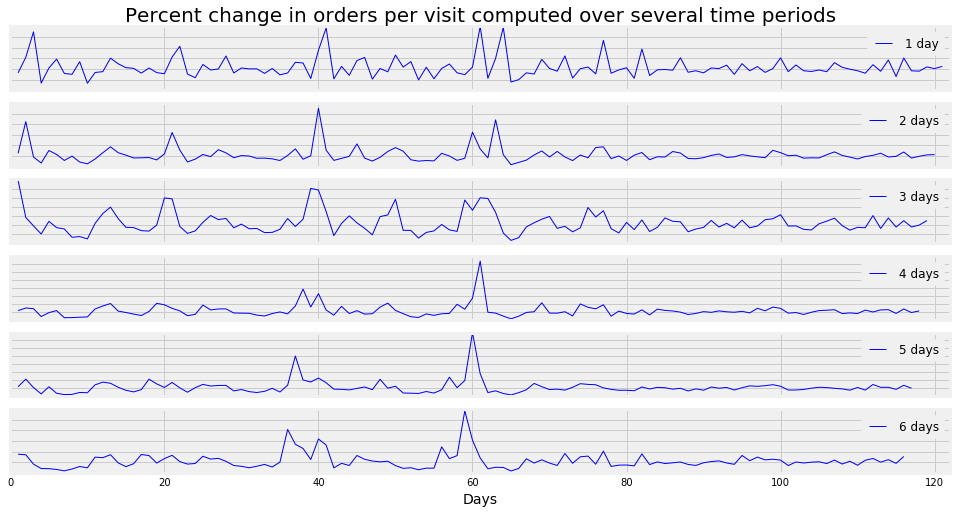

In [212]:
f, axarr = plt.subplots(6, sharex=True, figsize=(15,8), dpi=100)

axarr[0].plot(marketing_0.Day, marketing_0.orders_per_visit_percent_change_1day, color="blue", linewidth=1.0, 
              linestyle="-", label = '-1 day')
axarr[0].set_title('Percent change in orders per visit computed over several time periods', fontsize=20)
axarr[0].yaxis.set_ticklabels([])
axarr[0].legend(loc="upper right")

axarr[1].plot(marketing_0.Day, marketing_0.orders_per_visit_percent_change_2day, color="blue", linewidth=1.0, 
              linestyle="-", label = '-2 days')
axarr[1].yaxis.set_ticklabels([])
axarr[1].legend(loc="upper right")

axarr[2].plot(marketing_0.Day, marketing_0.orders_per_visit_percent_change_3day, color="blue", linewidth=1.0, 
              linestyle="-", label = '-3 days')
axarr[2].yaxis.set_ticklabels([])
axarr[2].legend(loc="upper right")

axarr[3].plot(marketing_0.Day, marketing_0.orders_per_visit_percent_change_4day, color="blue", linewidth=1.0, 
              linestyle="-", label='-4 days')
axarr[3].yaxis.set_ticklabels([])
axarr[3].legend(loc="upper right")

axarr[4].plot(marketing_0.Day, marketing_0.orders_per_visit_percent_change_5day, color="blue", linewidth=1.0, 
              linestyle="-", label='-5 days')
axarr[4].yaxis.set_ticklabels([])
axarr[4].legend(loc="upper right")

axarr[5].plot(marketing_0.Day, marketing_0.orders_per_visit_percent_change_6day, color="blue", linewidth=1.0, 
              linestyle="-", label = '-6 days')
axarr[5].yaxis.set_ticklabels([])
axarr[5].legend(loc="upper right")

axarr[5].set_xlabel('Days', fontsize=14)
axarr[5].set_xlim(0,122)

We are using negative time periods in order to avoid loising information in the fiorst few days of the series. As can be seen in the above plots, there is a consistent peak around day 40 which is not present in the precedeing days across all plots. 

(0, 122)

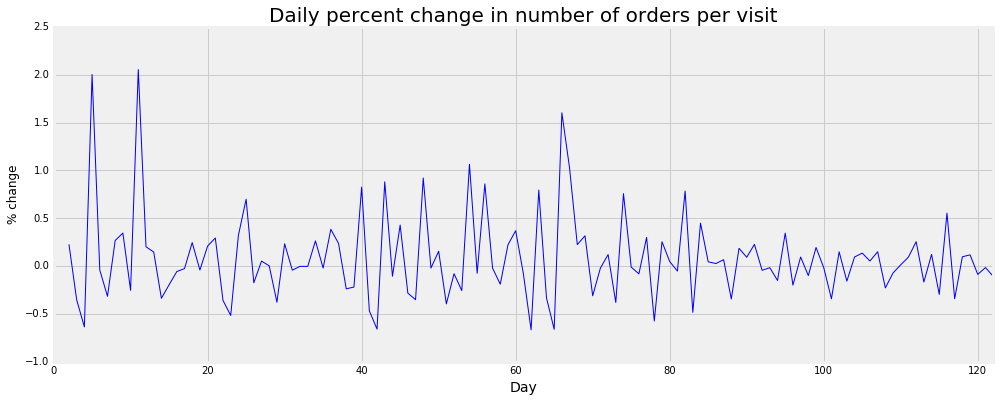

In [181]:
marketing_0['orders_per_visit_percent_change'] = marketing_0['orders_per_visit'].pct_change(periods=1)

fig = plt.figure(figsize=(15,6))
plt.plot(marketing_0.Day, marketing_0['orders_per_visit_percent_change'], color="blue", linewidth=1.0, linestyle="-")
plt.xlabel('Day', fontsize=14)
plt.ylabel('% change')
plt.title('Daily percent change in number of orders per visit', fontsize=20)
plt.xlim(0,122)

(0, 122)

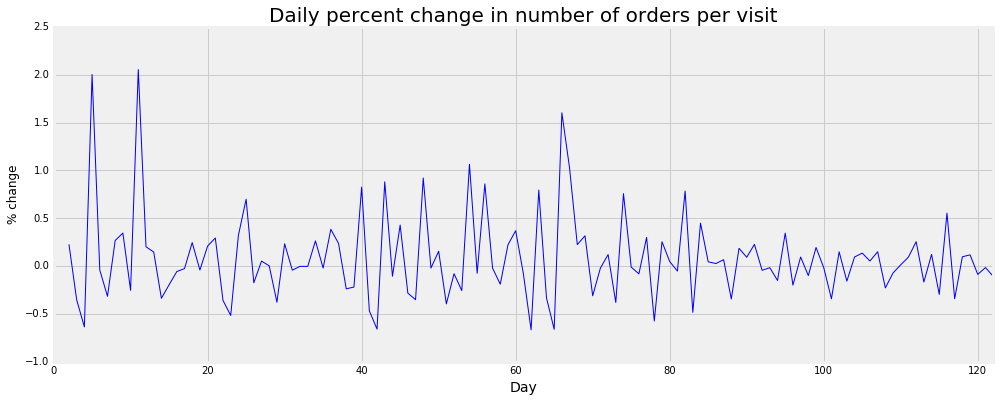

In [181]:
marketing_0['orders_per_visit_percent_change'] = marketing_0['orders_per_visit'].pct_change(periods=1)

fig = plt.figure(figsize=(15,6))
plt.plot(marketing_0.Day, marketing_0['orders_per_visit_percent_change'], color="blue", linewidth=1.0, linestyle="-")
plt.xlabel('Day', fontsize=14)
plt.ylabel('% change')
plt.title('Daily percent change in number of orders per visit', fontsize=20)
plt.xlim(0,122)

As seen in the above plot, there are several points in time in which there are increases in the daily average number of orders per visit: the two most prominent ones happen between days 0 and 20. Let's take a closer look:

(0, 20)

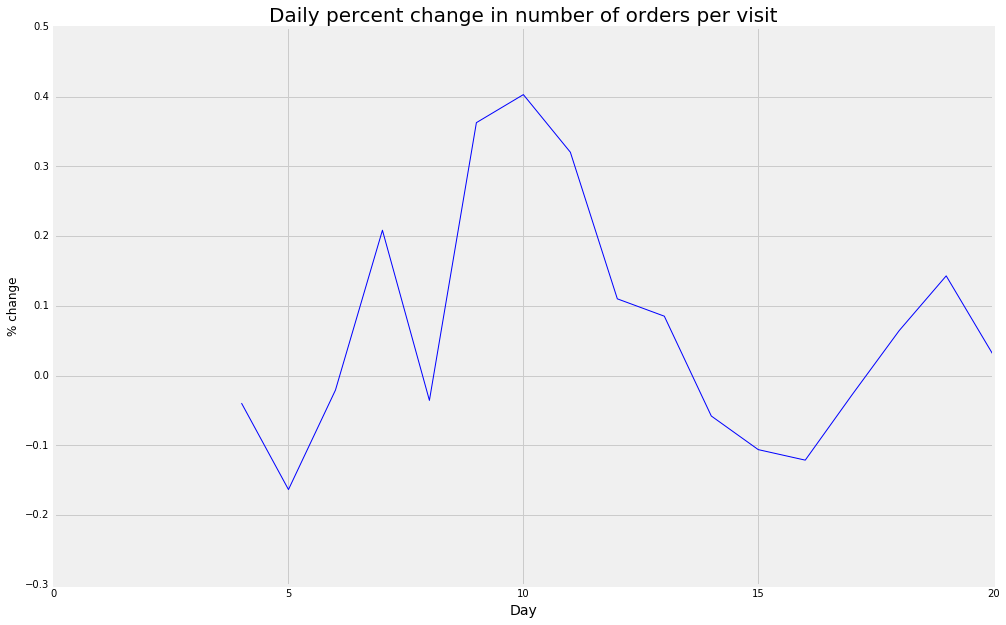

In [164]:
fig = plt.figure(figsize=(15,10))

plt.plot(marketing_0.Day, marketing_0['orders_per_visit_percent_change'], color="blue", linewidth=1.0, linestyle="-")
plt.xlabel('Day', fontsize=14)
plt.ylabel('% change')
plt.title('Daily percent change in number of orders per visit', fontsize=20)
plt.xlim(0,20)

The first increase in the number of orders per visit happens on day 5; therefore we conclude that the promotion started on day 5.

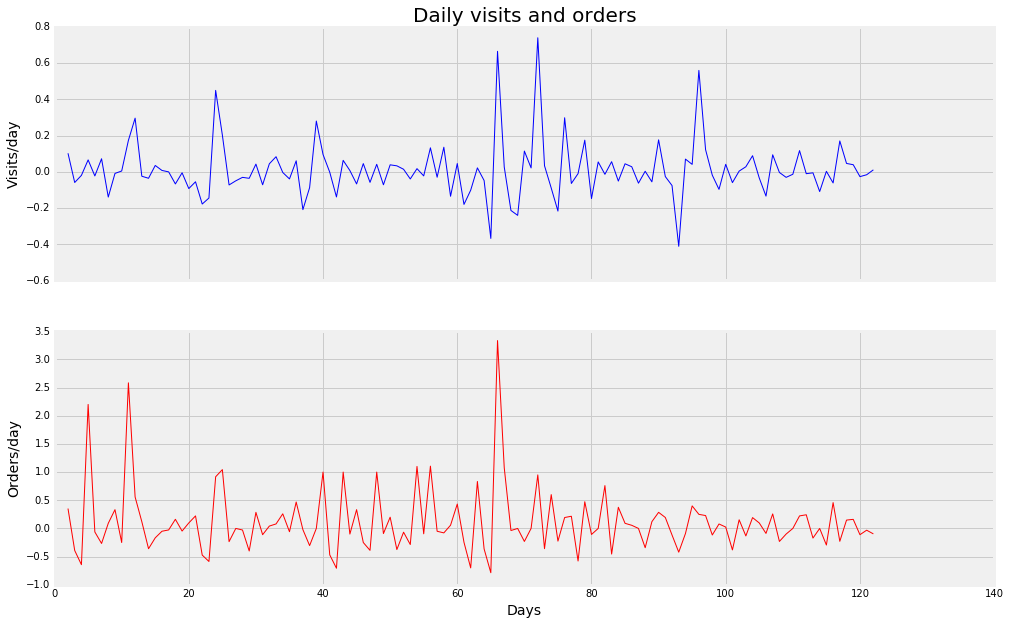

In [50]:
f, axarr = plt.subplots(2, sharex=True, figsize=(15,10), dpi=100)

axarr[0].plot(marketing_0.Day, marketing_0.visits.pct_change(), color="blue", linewidth=1.0, linestyle="-")
axarr[0].set_title('Daily visits and orders', fontsize=20)
axarr[0].set_ylabel('Visits/day', fontsize=14)

axarr[1].plot(marketing_0.Day, marketing_0.orders.pct_change(), color="red", linewidth=1.0, linestyle="-")
axarr[1].set_ylabel('Orders/day', fontsize=14)
axarr[1].set_xlabel('Days', fontsize=14)

From the above plots there does not seem to be a particular point in time associated to the start of the promotion

## 1.3 Normalisation

In order to proceed with the analysis the 'visits' and 'order' time series will be normalised in order to ensure that both time series will have similar numerical values.

In [22]:
marketing_0['visits_normalised'] = (marketing_0['visits'] - 
                                    marketing_0['visits'].mean())/(marketing_0['visits'].max() 
                                    - marketing_0['visits'].min())  

In [23]:
marketing_0['orders_normalised'] = (marketing_0['orders'] - 
                                    marketing_0['orders'].mean())/(marketing_0['orders'].max() 
                                    - marketing_0['orders'].min())  

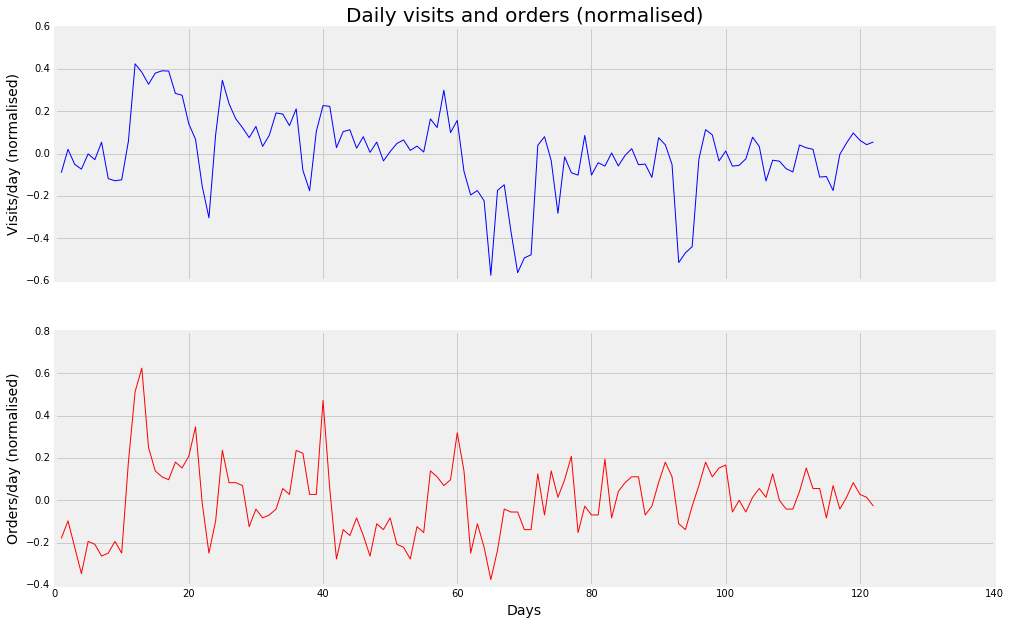

In [41]:
f, axarr = plt.subplots(2, sharex=True, figsize=(15,10), dpi=100)

axarr[0].plot(marketing_0.Day, marketing_0.visits_normalised, color="blue", linewidth=1.0, linestyle="-")
axarr[0].set_title('Daily visits and orders (normalised)', fontsize=20)
axarr[0].set_ylabel('Visits/day (normalised)', fontsize=14)

axarr[1].plot(marketing_0.Day, marketing_0.orders_normalised, color="red", linewidth=1.0, linestyle="-")
axarr[1].set_ylabel('Orders/day (normalised)', fontsize=14)
axarr[1].set_xlabel('Days', fontsize=14)

## 1.3 Orders per visit

With the above normalised time series for 'orders' and 'visits' we will now calculate a new time series representing a quantity that is a proxy to the number of orders per visit; this particular quantity is a measure to quantify the impact of a promotion.

In [42]:
marketing_0['orders_per_visit_normalised'] = marketing_0['orders_normalised']/marketing_0['visits_normalised']

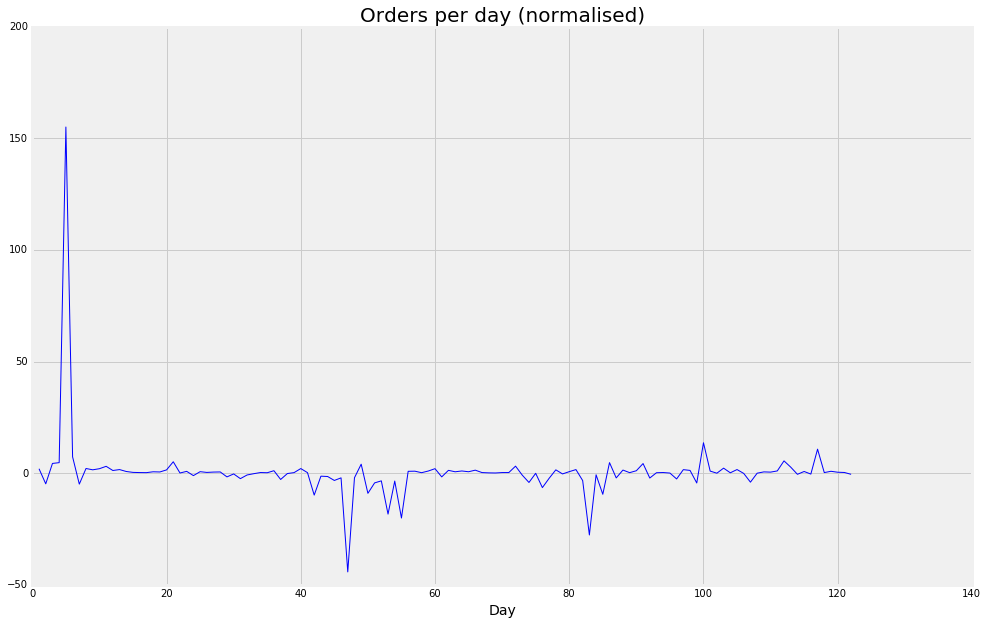

In [43]:
fig = plt.figure(figsize=(15,10))

plt.plot(marketing_0.Day, marketing_0['orders_per_visit_normalised'], color="blue", linewidth=1.0, linestyle="-")
plt.xlabel('Day', fontsize=14)
plt.title('Orders per day (normalised)', fontsize=20)

# Create a new figure of size 8x6 inches, using 100 dots per inch
plt.figure(figsize=(8,6), dpi=100)


As seen in the above plot, a sharp spike in the average number of orders per visit can be observed towards the start of the period under consideration. 

In [46]:
pelt(normal_mean(marketing_0['orders'], marketing_0['orders'].var()), marketing_0.shape[0])

[0]

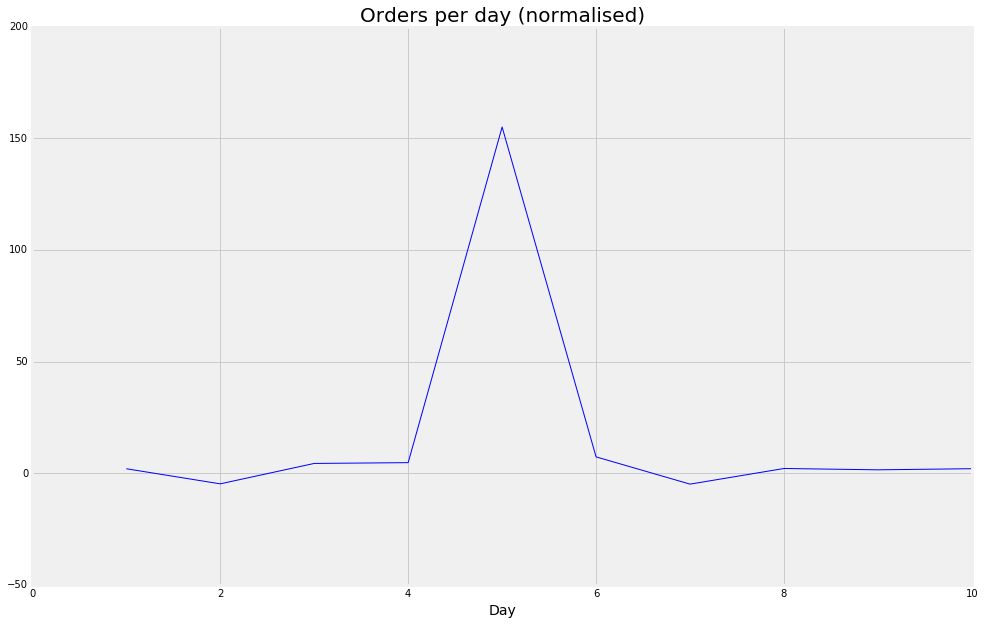

In [44]:
fig = plt.figure(figsize=(15,10))

plt.plot(marketing_0.Day, marketing_0['orders_per_visit_normalised'], color="blue", linewidth=1.0, linestyle="-")
plt.xlabel('Day', fontsize=14)
plt.title('Orders per day (normalised)', fontsize=20)
plt.xlim(0,10)

# Create a new figure of size 8x6 inches, using 100 dots per inch
plt.figure(figsize=(8,6), dpi=100)


From the above plot we can see that the increase in orders per visit happened on day 5 of the promotion

Completed in 1 hour

# 2 Clustering

## 2.1 Load data

In [4]:
clustering_0 = pd.read_csv('clustering_data.csv', header=None)

In [5]:
clustering_0.columns = ['F1', 'F2', 'F3', 'F4', 'F5']

In [6]:
clustering_0.head()

,F1,F2,F3,F4,F5
0,9.867585,21.787221,20.113157,15.892429,19.180627
1,-9.357452,-15.005907,-10.498652,-8.608220,-7.057452
2,-15.704679,-17.867917,-13.475520,-16.897009,-13.443890
3,21.199188,22.555756,18.634152,20.666434,17.455580
4,112.268019,97.873333,68.139400,164.779071,91.519554


In [7]:
clustering_0.shape

(5300, 5)

## 2.2 Feature standardisation

In [8]:
scl = StandardScaler()    

In [9]:
clustering_1 = scl.fit_transform(clustering_0)

## 2.3 Exploratory 3D plots

<IPython.core.display.Javascript object>


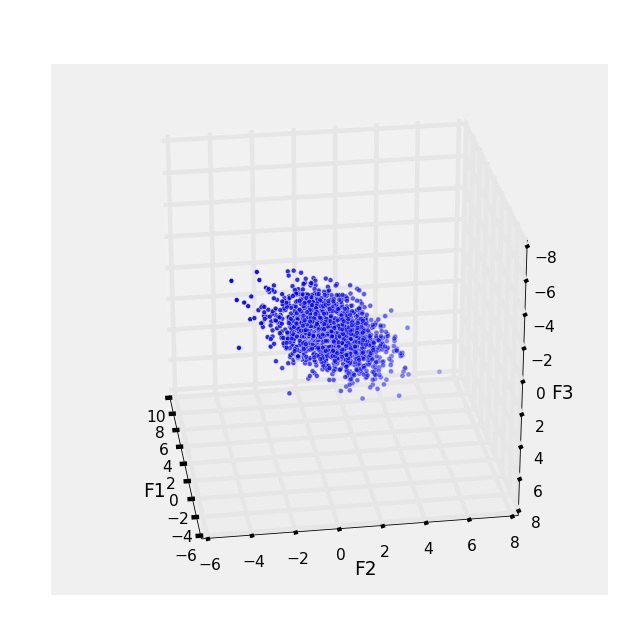

In [191]:
%matplotlib notebook
ax = fig.add_subplot(111, projection='3d')

threedee = plt.figure(figsize=(8,8)).gca(projection='3d')
threedee.scatter(clustering_1[:,0], clustering_1[:,1], clustering_1[:,2])
threedee.set_xlabel('F1')
threedee.set_ylabel('F2')
threedee.set_zlabel('F3')
plt.show()

<IPython.core.display.Javascript object>


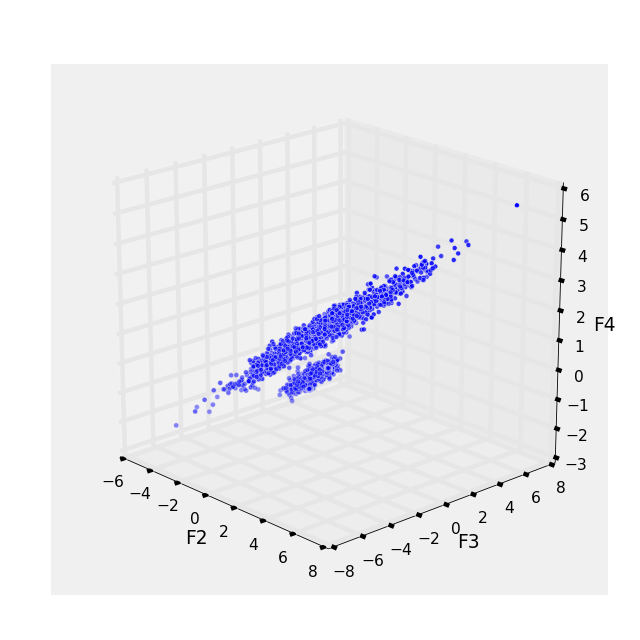

In [192]:
threedee = plt.figure(figsize=(8,8)).gca(projection='3d')
threedee.scatter(clustering_1[:,1], clustering_1[:,2], clustering_1[:,3])
threedee.set_xlabel('F2')
threedee.set_ylabel('F3')
threedee.set_zlabel('F4')
plt.show()

<IPython.core.display.Javascript object>


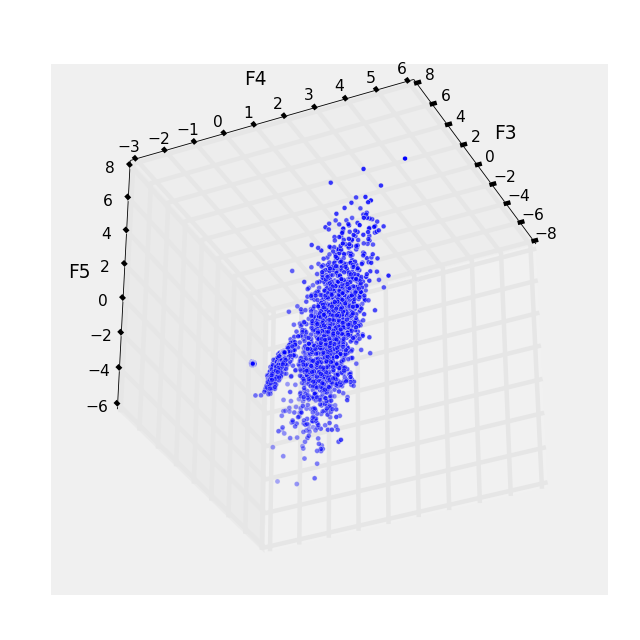

In [193]:
threedee = plt.figure(figsize=(8,8)).gca(projection='3d')
threedee.scatter(clustering_1[:,2], clustering_1[:,3], clustering_1[:,4])
threedee.set_xlabel('F3')
threedee.set_ylabel('F4')
threedee.set_zlabel('F5')
plt.show()

<IPython.core.display.Javascript object>


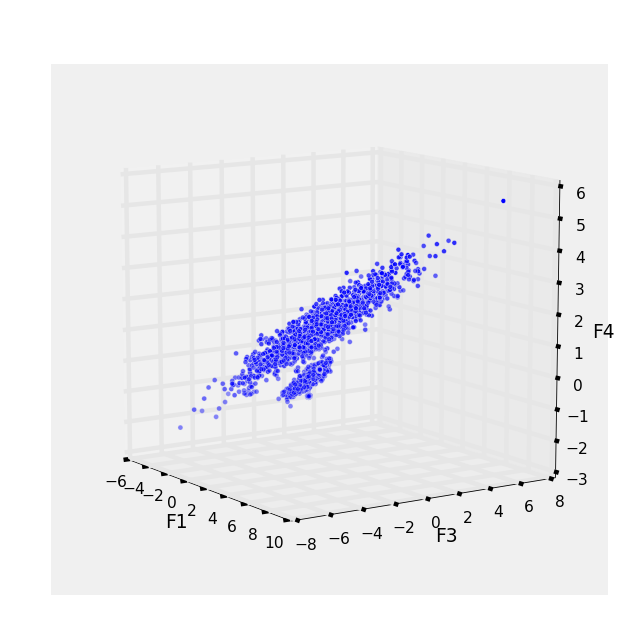

In [194]:
threedee = plt.figure(figsize=(8,8)).gca(projection='3d')
threedee.scatter(clustering_1[:,0], clustering_1[:,2], clustering_1[:,3])
threedee.set_xlabel('F1')
threedee.set_ylabel('F3')
threedee.set_zlabel('F4')
plt.show()

<IPython.core.display.Javascript object>


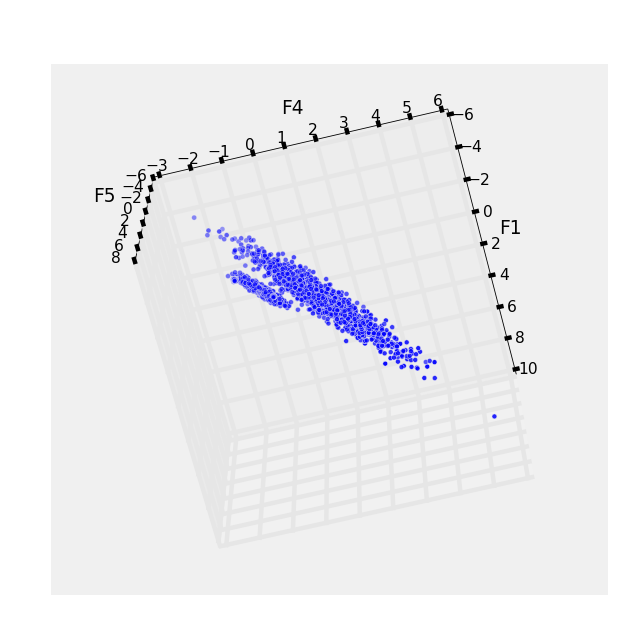

In [195]:
threedee = plt.figure(figsize=(8,8)).gca(projection='3d')
threedee.scatter(clustering_1[:,0], clustering_1[:,3], clustering_1[:,4])
threedee.set_xlabel('F1')
threedee.set_ylabel('F4')
threedee.set_zlabel('F5')
plt.show()

## 2.4 PCA

In [197]:
pca = PCA(n_components=None)

In [198]:
clustering_1_pca = pca.fit_transform(clustering_1)

In [199]:
pca.explained_variance_ratio_

array([ 0.7366454 ,  0.16452354,  0.07737197,  0.01595512,  0.00550396])

<IPython.core.display.Javascript object>


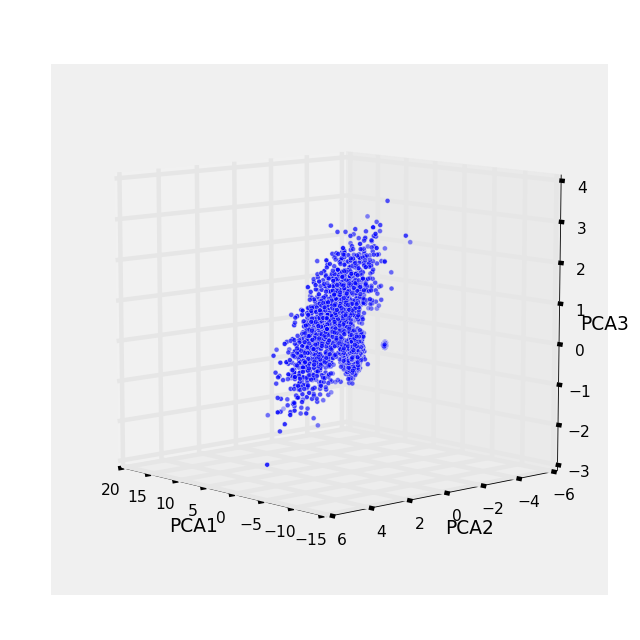

In [202]:
%matplotlib notebook
threedee = plt.figure(figsize=(8,8)).gca(projection='3d')
threedee.scatter(clustering_1_pca[:,0], clustering_1_pca[:,1], clustering_1_pca[:,2])
threedee.set_xlabel('PCA1')
threedee.set_ylabel('PCA2')
threedee.set_zlabel('PCA3')
plt.show()

## 2.5 k-means

In [256]:
km = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=RANDOM_STATE)

In [257]:
clusters_km = km.fit_predict(clustering_1)

In [258]:
km.inertia_

10056.390617032655

In [259]:
km.cluster_centers_

array([[ -1.04753158e+00,  -1.12285544e+00,  -4.66455200e-01,
         -8.41409371e-01,  -6.11362774e-01],
       [  1.91325948e+00,   1.84062673e+00,   1.49945405e+00,
          2.13190021e+00,   1.99944779e+00],
       [  1.41202880e-01,   1.90873416e-01,  -5.88478976e-02,
          1.54269886e-03,  -8.35545426e-02]])

In [260]:
centers = km.cluster_centers_

<IPython.core.display.Javascript object>


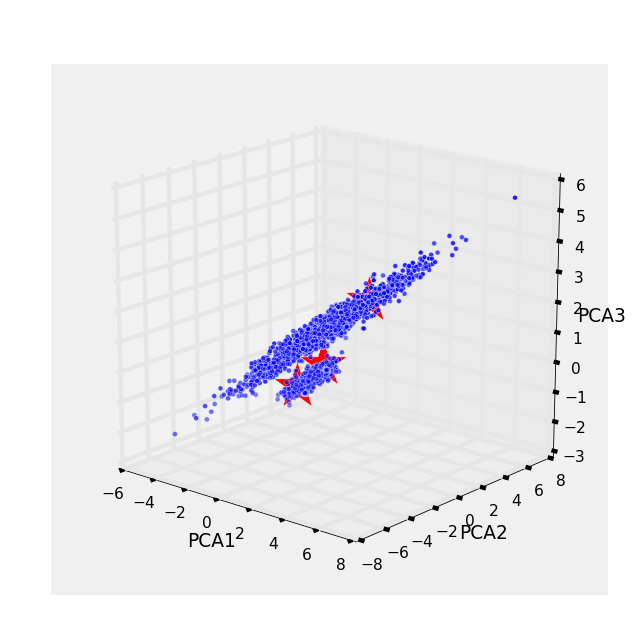

In [266]:
%matplotlib notebook
threedee = plt.figure(figsize=(8,8)).gca(projection='3d')
threedee.scatter(clustering_1[:,1], clustering_1[:,2], clustering_1[:,3])
threedee.set_xlabel('PCA1')
threedee.set_ylabel('PCA2')
threedee.set_zlabel('PCA3')
threedee.scatter(centers[0,1], centers[0,2], centers[0,3], c='red', s=2000, marker = '*')
threedee.scatter(centers[1,1], centers[1,2], centers[1,3], c='red', s=2000, marker = '*')
threedee.scatter(centers[2,1], centers[2,2], centers[2,3], c='red', s=2000, marker = '*')

plt.show()

### 2.5.1 Elbow curve for k-means

In [274]:
distortions = []
for i in range(1, 20):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=RANDOM_STATE)
    km.fit(clustering_1)
    distortions.append(km.inertia_)

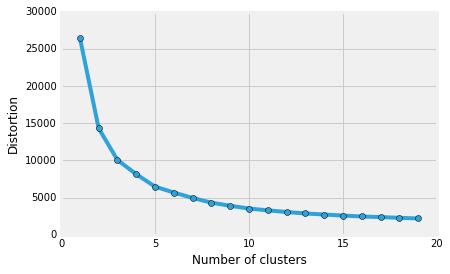

In [275]:
%matplotlib inline
plt.plot(range(1,20), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')

### 2.5.2 Silhouette plots

In [25]:
km = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=RANDOM_STATE)
y_km = km.fit_predict(clustering_1)

In [26]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]

In [27]:
silhouette_vals = silhouette_samples(clustering_1, y_km, metric='euclidean')

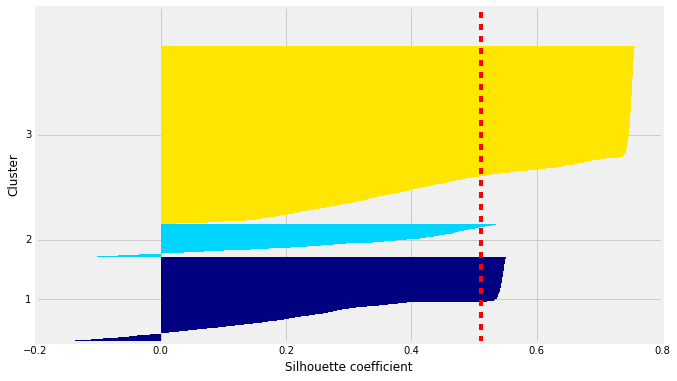

In [28]:
plt.figure(figsize=(10,6), dpi=80)
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

## 2.6 DBSCAN

In [424]:
db = DBSCAN(eps=0.2, min_samples=20, metric='euclidean')

In [425]:
db.fit(clustering_1)

DBSCAN(algorithm='auto', eps=0.2, leaf_size=30, metric='euclidean',
    min_samples=20, n_jobs=1, p=None)

In [426]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [427]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

In [428]:
n_clusters_

2

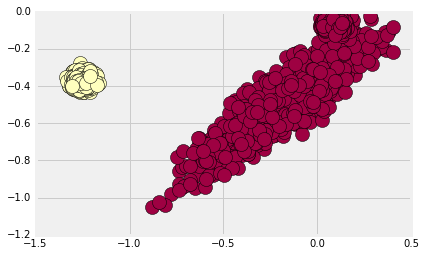

In [438]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = clustering_1[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 4], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

#     xy = X[class_member_mask & ~core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=6)

## 2.7 Cluster generation

### 2.7.1 Original data

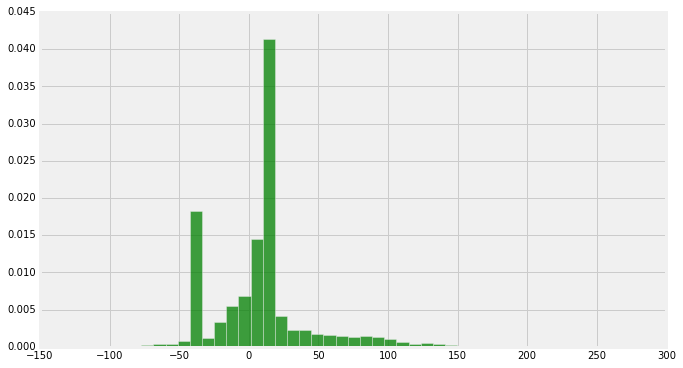

In [444]:
plt.figure(figsize=(10,6), dpi=80)
n, bins, patches = plt.hist(clustering_0['F1'], 50, normed=1, facecolor='green', alpha=0.75)

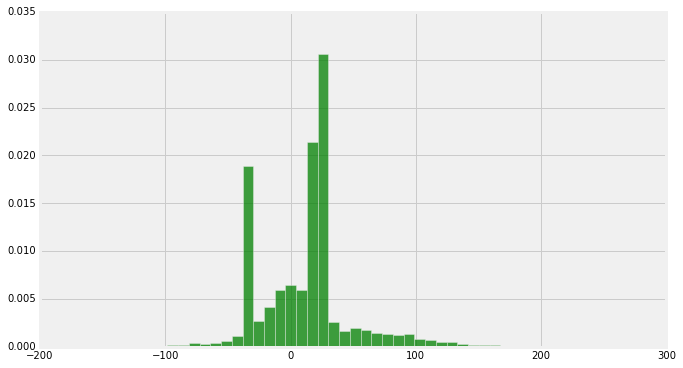

In [446]:
plt.figure(figsize=(10,6), dpi=80)
n, bins, patches = plt.hist(clustering_0['F2'], 50, normed=1, facecolor='green', alpha=0.750)

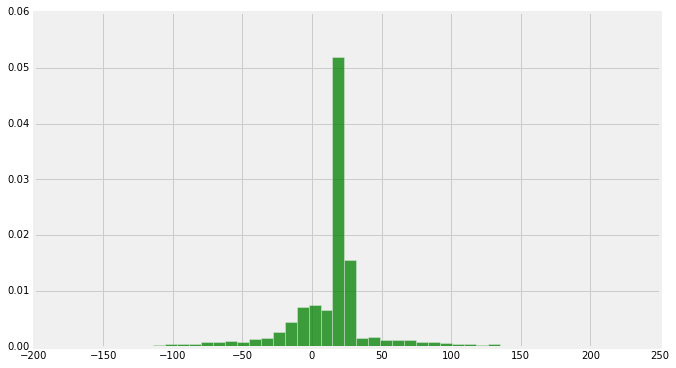

In [447]:
plt.figure(figsize=(10,6), dpi=80)
n, bins, patches = plt.hist(clustering_0['F3'], 50, normed=1, facecolor='green', alpha=0.750)

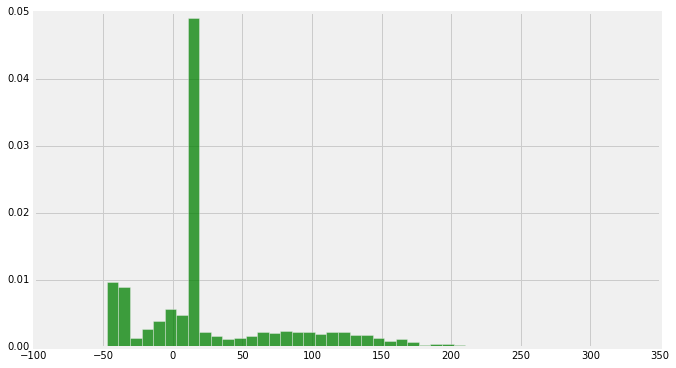

In [448]:
plt.figure(figsize=(10,6), dpi=80)
n, bins, patches = plt.hist(clustering_0['F4'], 50, normed=1, facecolor='green', alpha=0.750)

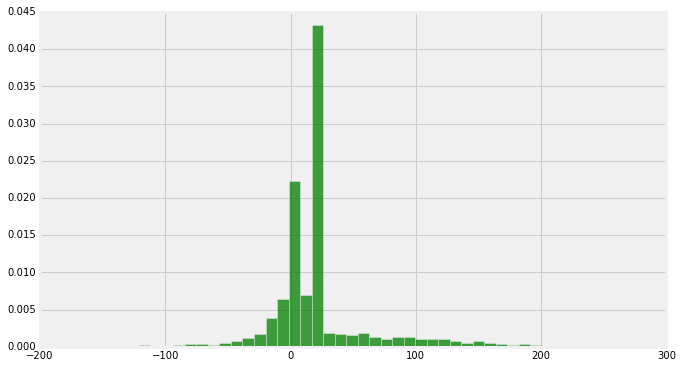

In [449]:
plt.figure(figsize=(10,6), dpi=80)
n, bins, patches = plt.hist(clustering_0['F5'], 50, normed=1, facecolor='green', alpha=0.750)

### 2.7.2 Standardised data

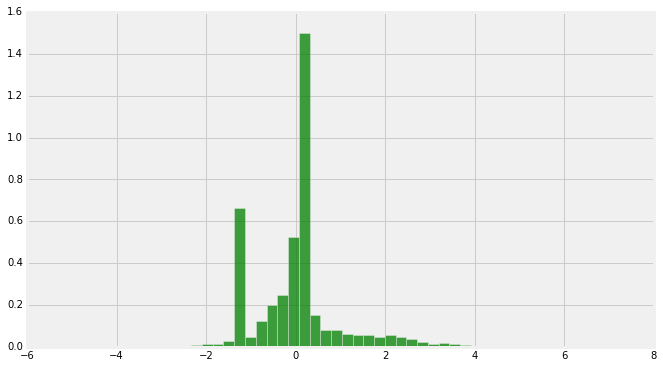

In [10]:
plt.figure(figsize=(10,6), dpi=80)
n, bins, patches = plt.hist(clustering_1[:,0], 50, normed=1, facecolor='green', alpha=0.75)

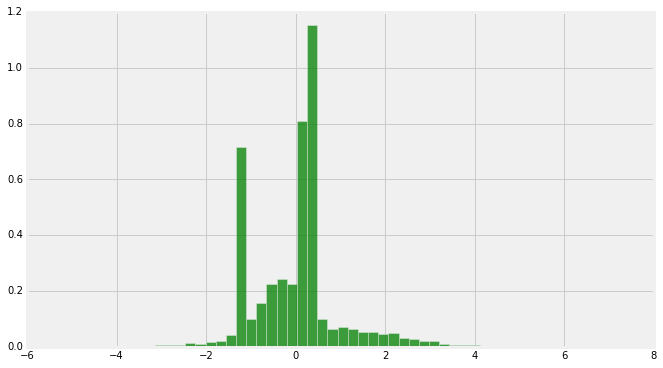

In [11]:
plt.figure(figsize=(10,6), dpi=80)
n, bins, patches = plt.hist(clustering_1[:,1], 50, normed=1, facecolor='green', alpha=0.750)

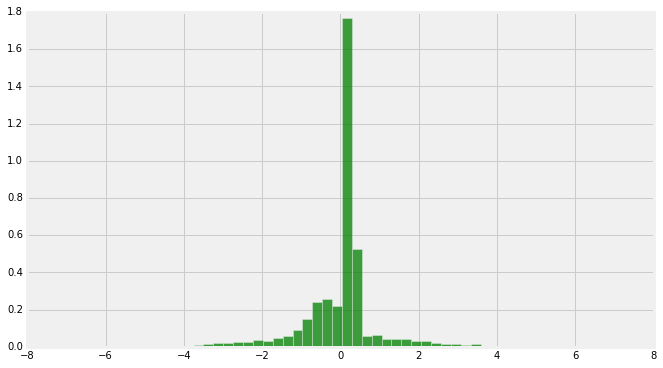

In [12]:
plt.figure(figsize=(10,6), dpi=80)
n, bins, patches = plt.hist(clustering_1[:,2], 50, normed=1, facecolor='green', alpha=0.750)

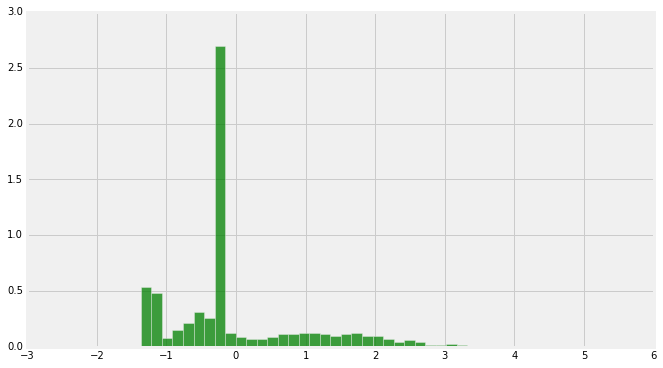

In [13]:
plt.figure(figsize=(10,6), dpi=80)
n, bins, patches = plt.hist(clustering_1[:,3], 50, normed=1, facecolor='green', alpha=0.750)

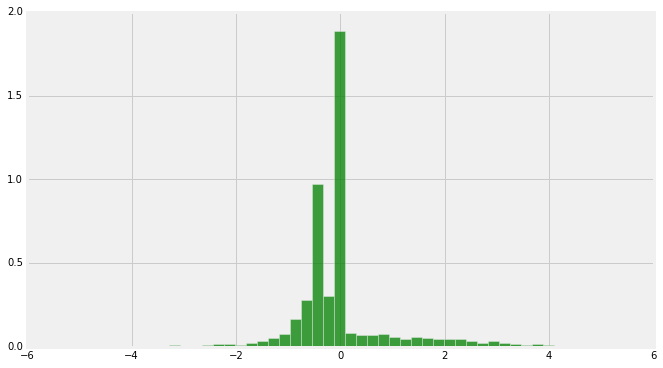

In [14]:
plt.figure(figsize=(10,6), dpi=80)
n, bins, patches = plt.hist(clustering_1[:,4], 50, normed=1, facecolor='green', alpha=0.750)

### 2.7.1 Cluster generation with make_blobs

In [2]:
X, y = make_blobs(n_samples=5300, n_features=5, centers=2, cluster_std=0.5, shuffle=True, random_state=RANDOM_STATE)

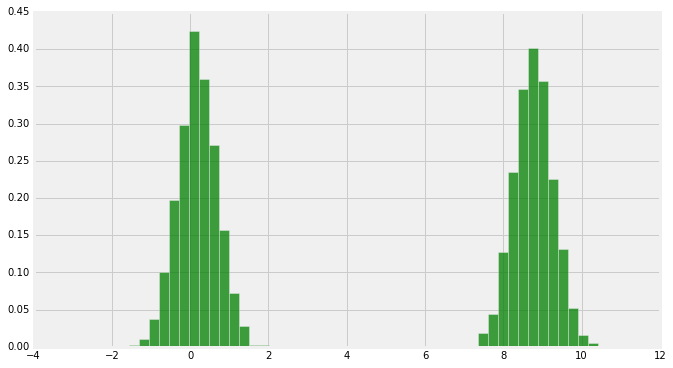

In [15]:
plt.figure(figsize=(10,6), dpi=80)
n, bins, patches = plt.hist(X[:,0], 50, normed=1, facecolor='green', alpha=0.75)

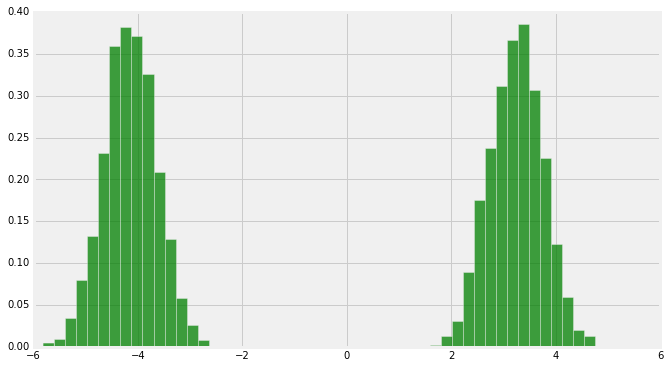

In [16]:
plt.figure(figsize=(10,6), dpi=80)
n, bins, patches = plt.hist(X[:,1], 50, normed=1, facecolor='green', alpha=0.750)

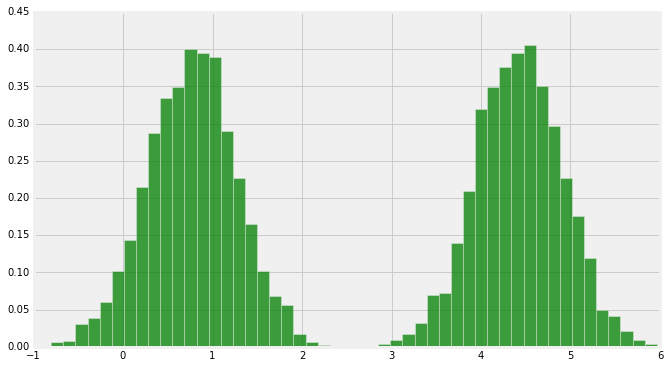

In [18]:
plt.figure(figsize=(10,6), dpi=80)
n, bins, patches = plt.hist(X[:,2], 50, normed=1, facecolor='green', alpha=0.750)

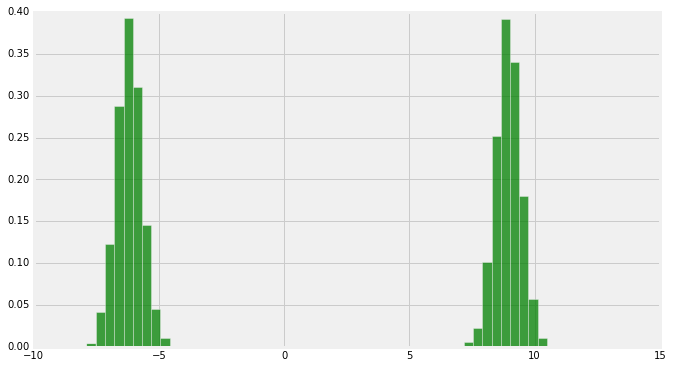

In [19]:
plt.figure(figsize=(10,6), dpi=80)
n, bins, patches = plt.hist(X[:,3], 50, normed=1, facecolor='green', alpha=0.750)

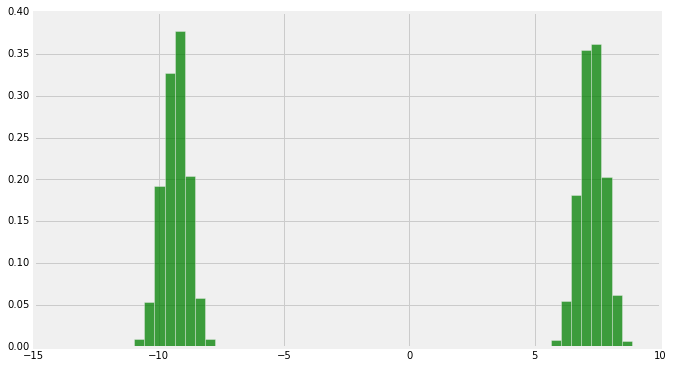

In [20]:
plt.figure(figsize=(10,6), dpi=80)
n, bins, patches = plt.hist(X[:,4], 50, normed=1, facecolor='green', alpha=0.750)

In [62]:
import changefinder
import numpy as np


class TestChangeFinder():
    def setup(self):
        self._term = 30
        self._smooth = 7
        self._order = 1
        self._arima_order = (1, 0, 0)
        self._data = np.concatenate([np.random.rand(300)+5,
                                     np.random.rand(300)+10,
                                     np.random.rand(300)+5,
                                     np.random.rand(300)])

    def test_changefinder(self):
        cf = changefinder.ChangeFinder(r=0.1, order=self._order, smooth=self._smooth)
        for i in self._data:
            cf.update(i)

    def test_changefinderarima(self):
        cf = changefinder.ChangeFinderARIMA(term=self._term, smooth=self._smooth, order=self._arima_order)
        for i in self._data:
            cf.update(i)

In [63]:
chfin = TestChangeFinder()

In [72]:
chfin.setup()

In [74]:
chfin.test_changefinder()

In [80]:
chfin._data

array([ 5.55731537,  5.89201702,  5.03029889, ...,  0.73172265,
        0.55130753,  0.88480462])

In [81]:
chfin.update()

AttributeError: TestChangeFinder instance has no attribute 'update'

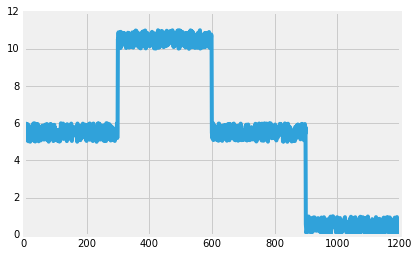

In [82]:
plt.plot(chfin._data)

In [83]:
theData = chfin._data

In [86]:
import changefinder
clf = changefinder.ChangeFinder()

In [87]:
clf.update(theData)

0.0